In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# from nltk import download as nltk_download
# from nltk import tokenize, RegexpTokenizer
# from nltk.corpus import stopwords
# nltk_download('punkt')
# nltk_download('stopwords')
# from nltk.stem.snowball import SnowballStemmer


data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
# data_filename = "bs4_nltk.pkl"
# data_filename = "bs4.pkl"
# df_base = pd.read_pickle(data_path + data_filename)

# body_corpus = load(data_path + 'body_corpus.joblib')

In [4]:
df_lemma = pd.read_pickle(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = pd.read_pickle(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))





In [5]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

# Vector Embed

In [7]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
VOCAB_SIZE = 4000
# SEQUENCE_LENGTH = 128
SEQUENCE_LENGTH = 128
# NGRAMS=(1,2)
NGRAMS=None

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     input_shape=(4000,),
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    ngrams=NGRAMS,)

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# text_ds = train_data.map(lambda x, y: x)
text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [15]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 48
DROPOUT = .35
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
    tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
#     tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.03)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [16]:
history = model.fit(
    body_train_data,
    epochs=10,
    validation_data=body_valid_data,
)

Epoch 1/10
2411/2411 [==============================] - 34s 14ms/step - loss: 0.1506 - patr: 0.2281 - recall: 0.1763 - auc: 0.8461 - fp: 7664.0344 - fn: 70390.3412 - tp: 11904.7790 - accuracy: 0.9728 - precision: 0.6086 - val_loss: 0.0960 - val_patr: 0.2881 - val_recall: 0.0715 - val_auc: 0.8830 - val_fp: 1333.0000 - val_fn: 26719.0000 - val_tp: 2058.0000 - val_accuracy: 0.9715 - val_precision: 0.6069
Epoch 2/10
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0904 - patr: 0.3630 - recall: 0.1192 - auc: 0.8964 - fp: 3786.8437 - fn: 49513.4851 - tp: 7849.1215 - accuracy: 0.9726 - precision: 0.6528 - val_loss: 0.0727 - val_patr: 0.6352 - val_recall: 0.2320 - val_auc: 0.9424 - val_fp: 1900.0000 - val_fn: 22100.0000 - val_tp: 6677.0000 - val_accuracy: 0.9756 - val_precision: 0.7785
Epoch 3/10
2411/2411 [==============================] - 32s 13ms/step - loss: 0.0736 - patr: 0.6125 - recall: 0.2660 - auc: 0.9383 - fp: 5525.6285 - fn: 41678.4871 - tp: 15684.8213 - accuracy

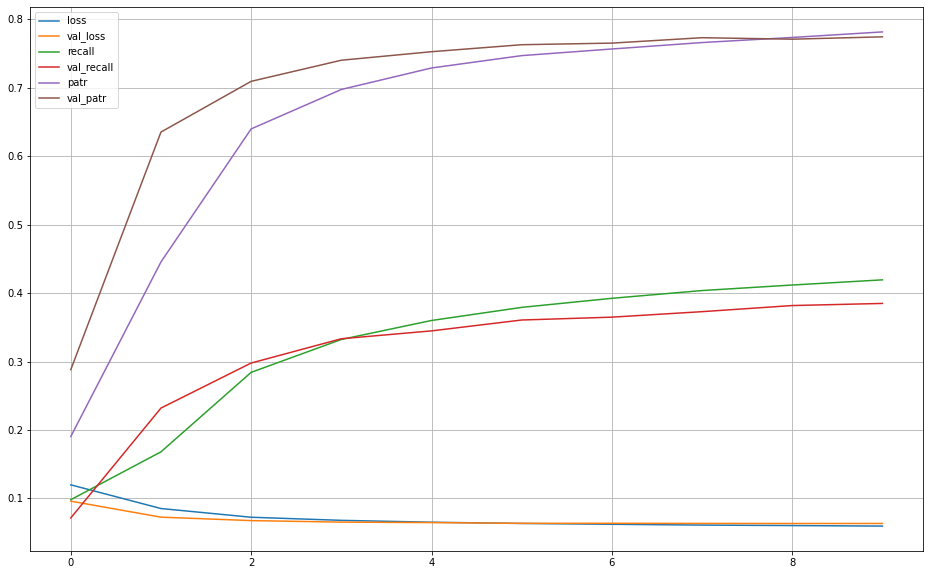

In [17]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [47]:
history.model

# Vector Embed LSTM

In [20]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128

ds_body =  tf.data.Dataset.from_tensor_slices((df_lemma['Body'][:COUNT], y_tags[:COUNT]))
ds_body_train, ds_body_valid = ds_body.take(ds_body.cardinality().numpy()*SPLIT_RATIO), ds_body.skip(ds_body.cardinality().numpy()*SPLIT_RATIO)
body_train_data = ds_body_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
body_valid_data = ds_body_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
VOCAB_SIZE = 5000
SEQUENCE_LENGTH = 96
# NGRAMS=(1,2)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     ngrams=NGRAMS,
#     output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = body_train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [27]:
# EMBEDDING_DIM = 48
EMBEDDING_DIM = 42
DROPOUT = .4
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        EMBEDDING_DIM,
#         recurrent_dropout=0.1,
    )),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
#     tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.02)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [ ]:
history = model.fit(
    body_train_data,
    epochs=9,
    validation_data=body_valid_data,
)

Epoch 1/9
4821/4821 [==============================] - 371s 76ms/step - loss: 0.1103 - patr: 0.2070 - recall: 0.0710 - auc: 0.8161 - fp: 3910.1080 - fn: 51953.2387 - tp: 5373.5035 - accuracy: 0.9700 - precision: 0.4599 - val_loss: 0.0721 - val_patr: 0.6348 - val_recall: 0.2683 - val_auc: 0.9423 - val_fp: 2534.0000 - val_fn: 21055.0000 - val_tp: 7722.0000 - val_accuracy: 0.9760 - val_precision: 0.7529
Epoch 2/9
4821/4821 [==============================] - 221s 46ms/step - loss: 0.0729 - patr: 0.6308 - recall: 0.3034 - auc: 0.9364 - fp: 6561.5670 - fn: 39329.2287 - tp: 17997.3100 - accuracy: 0.9765 - precision: 0.7275 - val_loss: 0.0638 - val_patr: 0.7639 - val_recall: 0.3575 - val_auc: 0.9528 - val_fp: 2588.0000 - val_fn: 18490.0000 - val_tp: 10287.0000 - val_accuracy: 0.9786 - val_precision: 0.7990
Epoch 3/9
4821/4821 [==============================] - 376s 78ms/step - loss: 0.0653 - patr: 0.7374 - recall: 0.3814 - auc: 0.9499 - fp: 7091.4538 - fn: 35150.0212 - tp: 22177.1765 - accurac

In [74]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'precision_at_recall_9', 'val_precision_at_recall_9' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

KeyError: "['val_precision_at_recall_9', 'precision_at_recall_9'] not in index"

In [30]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 [==============================] - 1s 23ms/step - loss: 0.0925 - auc: 0.8844
Test Loss: 0.09254556894302368
Test Accuracy: 0.884442925453186


(0.0, 0.14245018772780896)

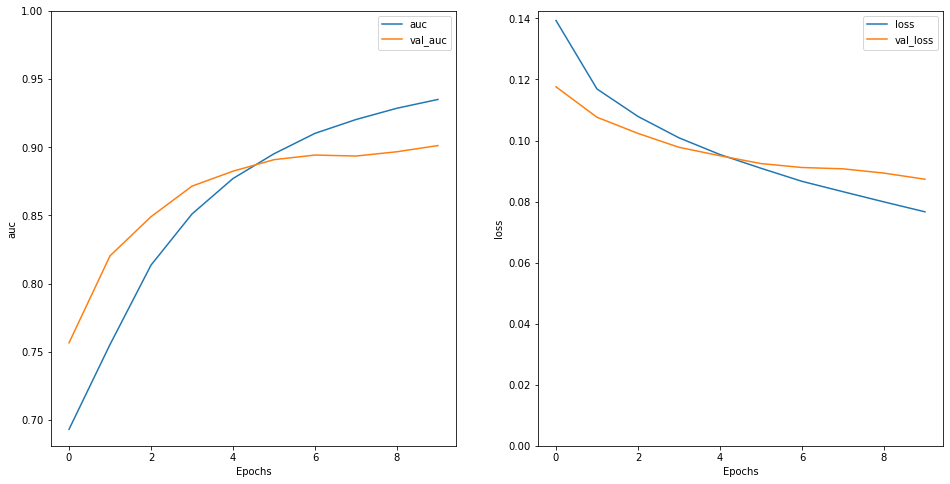

In [13]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

ds_title =  tf.data.Dataset.from_tensor_slices((df['Title'][:COUNT], y_tags[:COUNT]))
ds_title_train, ds_title_valid = ds_title.take(ds_title.cardinality().numpy()*SPLIT_RATIO), ds_title.skip(ds_title.cardinality().numpy()*SPLIT_RATIO)
title_train_data = ds_title_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
title_valid_data = ds_title_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
SEQUENCE_LENGTH = 96
# NGRAMS=(1,2)

vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
#     ngrams=NGRAMS,
#     output_sequence_length=SEQUENCE_LENGTH,
    )

text_ds = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
EMBEDDING_DIM = 48
DROPOUT = .4
LABEL_SMOOTHING =0

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
#         mask_zero=True,
        name="embedding"),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        EMBEDDING_DIM,
#         recurrent_dropout=0.1,
    )),
    tf.keras.layers.Dense(EMBEDDING_DIM,
            activation='relu',
                ),
#     tf.keras.layers.Dropout(DROPOUT),
#     tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu', 
#                 ),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(51, activation='sigmoid'),
])

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.02)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
# model.summary()

In [ ]:
history = model.fit(
    train_data,
    epochs=9,
    validation_data=test_data,
)

# Vector concat

In [ ]:
LABEL_SMOOTHING = 0
optimizer = keras.optimizers.Adam(learning_rate=0.003)
loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING)

In [ ]:
COUNT=100000
SPLIT_RATIO = .8
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 128
# ds_concat =  tf.data.Dataset.from_tensor_slices(((X_title[:COUNT].toarray(), X_body[:COUNT].toarray()), y_tags[:COUNT]))
ds_concat =  tf.data.Dataset.from_tensor_slices(((df_title[:COUNT], df_body[:COUNT].toarray()), y_tags[:COUNT]))
ds_concat_train, ds_concat_valid = ds_concat.take(ds_concat.cardinality().numpy()*SPLIT_RATIO), ds_concat.skip(ds_concat.cardinality().numpy()*SPLIT_RATIO)
concat_train_data = ds_concat_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
concat_valid_data = ds_concat_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
DIM_TITLE = 24
# DROPOUT_TITLE = .25
DROPOUT_TITLE = .20
DIM_BODY = 48
# DROPOUT_BODY = .4
DROPOUT_BODY = .35
DROPOUT_CONCAT = .25

input_title = tf.keras.layers.Input(shape=(1000,), name="title_input")
hidden_title_1 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(input_title)
dropout_title_1 = tf.keras.layers.Dropout(DROPOUT_TITLE)(hidden_title_1)
# hidden_title_2 = tf.keras.layers.Dense(DIM_TITLE, activation='relu')(dropout_title_1)
# dropout_title_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_title_2)

input_body = tf.keras.layers.Input(shape=(4000,), name="body_input")
hidden_body_1 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(input_body)
dropout_body_1 = tf.keras.layers.Dropout(DROPOUT_BODY)(hidden_body_1)
# hidden_body_2 = tf.keras.layers.Dense(DIM_BODY, activation='relu')(dropout_body_1)
# dropout_body_2 = tf.keras.layers.Dropout(DROPOUT)(hidden_body_2)

# concat = tf.keras.layers.concatenate([dropout_title_2, dropout_body_2])
concat = tf.keras.layers.concatenate([dropout_title_1, dropout_body_1])
hidden_concat = tf.keras.layers.Dense(48, activation='relu')(concat)
dropout_concat = tf.keras.layers.Dropout(DROPOUT_CONCAT)(hidden_concat)

# output = tf.keras.layers.Dense(51, activation='sigmoid')(concat)
output = tf.keras.layers.Dense(51, activation='sigmoid')(dropout_concat)

model = tf.keras.Model(inputs=[input_title, input_body], outputs=[output])

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=metrics,
)
model.summary()

In [ ]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    concat_train_data,
    epochs=7,
    validation_data=concat_valid_data,
#     validation_steps=3,
#     callbacks=[tb_callback],
)

In [ ]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)